# Analysis of the Experimental Results
Apply multivariate analysis of the experimental results

## Questions to investigate
For each of the clustering methods which one provides the best clustering of stations for the variants of epsilon nad maxPts. Best clustering can be defined as:
1. Most number of clusters with most number of stations (i.e. least noise)
1. Maximum quality measure with the silhouette coefficient, calinzki-harabaz score, davis-bouldin score, and dunn index

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

#''' Dictionary of clustering processes to use with color pallet to make the coloring consistent across
#    all types of plots '''
#_dict_clust_procs = {0:"DBSCAN-auto",1:"HDBSCAN-best-eom",2:"HDBSCAN-best-leaf",3:"OPTICS-auto-xi",
#                     4:"OPTICS-auto-dbscan",5:"MEANSHIFT",6:"AGGLOMERATIVE",7:"AFFINITYPROPAGATION",8:"BIRCH",
#                     9:"GREEDY-random",10:"GREEDY-integer",11:"ASYNC-LPA-random",12:"LABEL-PROPAGATION",
#                     13:"GIRVAN-NEWMAN",14:"KMEANS",15:"SPECTRAL-discretize-lobpcg"}
#print("Dictionary of clustering process with parametric variations\n",_dict_clust_procs)

### Get station data

___Note:___ You may skip retrieving data and running the prolonged clustering process and simply work analyze the quality measures from the ```results.csv``` file stored in the ```experiments``` folder.

In [17]:
''' Get all stations  '''
import sys
sys.path.insert(1, '../lib')
import stations
import datetime

try:
    now = datetime.datetime.now()
    print ("Current run date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    print('Please wait while we retrieve GeoNet station inventory data')
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list, _ = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError

    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} active stations inside the main geographic land boundaries.')
    print(f'and {len(invalid_st_list)} active stations outside the main geographic land boundaries.')
    print('Complete')

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Current run date and time : 
2022-04-12 10:51:59
Please wait while we retrieve GeoNet station inventory data


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning:

The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.



In the inventory of 456 total station
There are 452 active stations inside the main geographic land boundaries.
and 4 active stations outside the main geographic land boundaries.
Complete


In [21]:
import pandas as pd

try:
    ''' Define the list of broadband station types to filter the station inventory data 
        "BH" : Broadband Weak Motion sensor measuring velocity sampled between 10 and 80 Hz,
        "BN" : Broadband Strong Motion sensor measuring acceleration sampled between 10-80 Hz, 
        "HH" : Broadband Weak Motion sensor measuring velocity sampled generally 100 or 200 Hz,
        "HN" : Broadband Strong Motion sensor measuring acceleration sampled generally 100 or 200 Hz,
        "LH" : Broadband Weak Motion sensor measuring velocity sampled nat 1Hz,
        "LN" : Broadband Strong Motion sensor measuring acceleration sampled at 1Hz,
    '''
    __lst_st_type_80Hz_above = ['BH','BN','HH','HN','LH','LN']
    lst_st_80Hz_above = [[st_name,st_type, st_lat,st_lon]
                         for st_name,st_type,st_lat,st_lon in st_list
                         if st_type in __lst_st_type_80Hz_above]
    station_df = pd.DataFrame(lst_st_80Hz_above, columns=['st_name','st_type','st_lat','st_lon'])

    ''' Initialize label column as -1 indicating individual stations to be noise to begin with '''
    l_label = [-1]*station_df.shape[0]
    station_df['label'] = -1
    station_df.set_index(['st_type','label'])

    print('%d stations of type %s are ready for clustering' % (station_df.shape[0],__lst_st_type_80Hz_above))

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

336 stations of type ['BH', 'BN', 'HH', 'HN', 'LH', 'LN'] are ready for clustering


### Get clustering sequence parameters

#### Set file names and parameters

In [102]:
''' Set relevant parameters used throughout all cells

    @_force_regularity = {'Absolute','Average','minPoints','None'}
       Absolute - is a brute force to check all constraints
       Average - checks if average degree of nodes in cluster >= minPts-1
       minPoints - simply checks for minimum samples and doesn't enforce regularity
       None - doesn't do anything but simply creates a list of simple graphs corresponding to each cluster
'''
_force_regularity = "Average"
print('Regularity enforcement: %s' % (_force_regularity))

''' Set file names to read clustering sequence and write results to;
    including writing clusters that cannot be validated for quality'''
''' complete run '''
_s_seq_input_file = "./cluster_runs.csv"
_s_results_file = "./results_"+_force_regularity+".csv"
_err_file_name = "./err_clustering_"+_force_regularity+".txt"

''' Naive-greed run - because it takes a long time '''
#_s_seq_input_file = "./cluster_runs_naivegreedy.csv"
#_s_results_file = "./results_naivegreedy_"+_force_regularity+".csv"
#_err_file_name = "./err_clustering_naivegreedy_"+_force_regularity+".txt"

''' Spectral determine K run - because it takes a long time '''
#_s_seq_input_file = "./cluster_runs_spectral_evalOptimRun.csv"
#_s_results_file = "./results_spectral_evalOptimRun_"+_force_regularity+".csv"
#_err_file_name = "./err_clustering_spectral_evalOptimRun_"+_force_regularity+".txt"

''' test run - for checking code'''
#_s_seq_input_file = "./test_cluster_runs.csv"
#_s_results_file = "./test_results_"+_force_regularity+".csv"
#_err_file_name = "./test_err_clustering_"+_force_regularity+".txt"

print('Data files to be used:')
print('...input  :%s ' % _s_seq_input_file)
print('...results:%s ' % _s_results_file)
print('...errors :%s ' % _err_file_name)
print("\nReady to run clustering")

Regularity enforcement: Average
Data files to be used:
...input  :./cluster_runs.csv 
...results:./results_Average.csv 
...errors :./err_clustering_Average.txt 

Ready to run clustering


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Run clustering strategies
___Skip this if already run and only analyzing the results___

In [44]:
''' Get clustering experiment sequence parameters from the spreadsheet '''
import pandas as pd
import sys; sys.path.insert(1, '../lib')
import cluster_quality as cq
import graph_clustering as gc
import cloud_clustering as cc
import importlib

if debug:
    import importlib
    cq = importlib.reload(cq)
    cc = importlib.reload(cc)
    gc = importlib.reload(gc)

import sys
import time
#import traceback

''' declare quality class, results dataframe, and number of erros '''
clust_quality = cq.cluster_quality_metric()
results_df_ = pd.DataFrame([])     # dataframe to store the results
#d_n_errs = 0

''' Load data from CSV '''
_run_seq_df = pd.read_csv(_s_seq_input_file)
_err_file=None
#d _err_file = open(_err_file_name,'w')     # start file to log all errors
_s_seq_name = None
_s_meth_name = None
_s_algo_name = None
_n_errs = 0

print('File %s contains clustering strategies for processes\n%s'
      % (_s_seq_input_file, sorted(_run_seq_df['name'].unique())))
print('Start clustering and acquire quality parameters for %d strategies' % _run_seq_df.shape[0])
print('This may take a while ...\n')
_run_seq_df.sort_values(by=['technique','name'])
for _n_exp_seq in range(_run_seq_df.shape[0]):
    s_clust_cls_, s_clust_name_, dict_params_ = clust_quality.get_seq_params(_run_seq_df, _n_exp_seq)
    ''' print current strategy name for monitoring progress '''
    if (_s_seq_name != s_clust_name_):
        _s_seq_name = s_clust_name_
        print('...Starting strategy %d with %s clustering.'
              % (_n_exp_seq, s_clust_name_))
    ''' Get clusters for given strategy with parameter dictionary '''
    st_clust_df_ = pd.DataFrame([])     # dataframe for the stations and cluster labels
#    print(dict_params_)
    st_clust_df_ = clust_quality.get_clusters(dict_params_,
                                              station_df,
                                              s_clust_cls_,
                                              s_clust_name_)

    ''' apply r-regularity to further validate the culsters '''
    if _force_regularity in ['Absolute','Average','minPoints','None']:
        _dict_reg_param = {"force_regularity":_force_regularity}
        st_clust_df_,lst_G_simple = clust_quality.get_r_regular_clusters(_dict_reg_param,st_clust_df_)

    _n_clusters = len([x for x in st_clust_df_['label'].unique() if x > -1])

    if _n_clusters > 1:
        clust_quality.set_quality_frame(clustering_name=s_clust_name_, **dict_params_)
#d        results_df_=results_df_.append(clust_quality.get_quality_metrics(st_clust_df_))
        results_df_=results_df_.append(clust_quality.get_quality_metrics(st_clust_df_,lst_G_simple))

        '''
        for H in lst_G_simple:
            _l_deg_diff = [dict_params_["minimum_samples"]-1-d for n, d in H.degree()
                           if (int(d) < int(dict_params_["minimum_samples"]-1) and H.nodes[n]["label"] > -1)]
            _deg_mean_abs_err=0
            if len(_l_deg_diff) > 0:
                print(_l_deg_diff)
                print(sorted([d for n,d in H.degree()]))
                _deg_mean_abs_err = sum(_l_deg_diff)/len(_l_deg_diff)
        '''
    else:
#d        if isinstance(_err_file,type(None)):
        if _n_errs <= 0:
            _err_file = open(_err_file_name,'w')     # start file to log all errors
        _n_errs += 1
        _s_err = s_clust_name_+': '+''.join(str(dict_params_.keys()))
        _s_err += '\n'+''.join(str(dict_params_.values()))+'\n'
        _err_file.write(_s_err)
#d        print('No results were added for %s' % _s_err)

if results_df_.shape[0] > 0:
    l_seq = list(range(0,(results_df_.shape[0])))
    results_df_.insert(0, 'Sequence', l_seq)
    results_df_.set_index('Sequence')
    results_df_.to_csv(_s_results_file, index=False)

if _n_errs > 0:
    _err_file.close()
    
print('\nOf %d sequences the quality metric results for %d sequences are stored in %s' 
      % (_n_exp_seq+1,_n_exp_seq+1-_n_errs,_s_results_file))
if not isinstance(_err_file,type(None)):
    print('%d error(s) for cluster strategy logged in %s' % (_n_errs,_err_file_name))


File ./cluster_runs.csv contains clustering strategies for processes
['AFFINITYPROPAGATION', 'AGGLOMERATIVE', 'ASYNC-LPA', 'BIRCH', 'DBSCAN', 'GIRVAN-NEWMAN', 'GREEDY', 'HDBSCAN', 'KMEANS', 'LPC', 'MEANSHIFT', 'OPTICS', 'SPECTRAL']
Start clustering and acquire quality parameters for 320 strategies
This may take a while ...

...Starting strategy 0 with DBSCAN clustering.
...Starting strategy 20 with HDBSCAN clustering.
...Starting strategy 60 with OPTICS clustering.
...Starting strategy 100 with AFFINITYPROPAGATION clustering.
...Starting strategy 120 with MEANSHIFT clustering.
...Starting strategy 140 with BIRCH clustering.
...Starting strategy 160 with GREEDY clustering.
...Starting strategy 200 with ASYNC-LPA clustering.
...Starting strategy 220 with LPC clustering.
...Starting strategy 240 with GIRVAN-NEWMAN clustering.
...Starting strategy 260 with AGGLOMERATIVE clustering.
...Starting strategy 280 with KMEANS clustering.
...Starting strategy 300 with SPECTRAL clustering.

Of 320 s

## Load, Prepare and Enrich Quality Metrics

In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#_s_seq_input_file = "./results.csv"
#_s_seq_input_file = "./results_kmeans.csv"
#_results_df=pd.read_csv(_s_seq_input_file)
_results_df=pd.read_csv(_s_results_file)
#_results_df.head()

lst_drop_cols = ['Sequence', 'Station Types', 'Station Quantity', 'Metric']
_results_df = _results_df.drop(lst_drop_cols,axis=1)

lst_norm_cols = list(["Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score",
                      "Dunn Index","Modularity","Conductance Average","Coverage Score","Performance Score"])
_results_df[lst_norm_cols] = _results_df[lst_norm_cols].apply(pd.to_numeric)
''' rename attributes '''
_results_df=_results_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_results_df.loc[_results_df.Name == "LPC", "Name"] = "LABEL PROPAGATION"
''' append algorithm and method to name '''
_results_df['Cluster Sequence'] = (_results_df['Name']+' '+_results_df['Algorithm']+
                                   ' '+_results_df['Method']+' '+_results_df['Seed'])
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("None","")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("   ","-")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace(" ","-")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.rstrip("-")
_results_df.info()
#print(_results_df['Cluster Sequence'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   maxDist                              260 non-null    float64
 1   minPts                               260 non-null    int64  
 2   Name                                 260 non-null    object 
 3   Algorithm                            260 non-null    object 
 4   Method                               260 non-null    object 
 5   Seed                                 260 non-null    object 
 6   Generated Cluster Count              260 non-null    int64  
 7   Valid Cluster Count                  260 non-null    int64  
 8   Clustered Station Count              260 non-null    int64  
 9   Unclsutered Noise Count              260 non-null    int64  
 10  Average Station Degree               260 non-null    float64
 11  Degree Weighted Mean Absolute Er

### skip this if already done once

In [4]:
''' Get the @_dict_clust_procs with @_results_df['Cluster Sequence'] values 
    for consistnent color coding with plots. Set _force_regularity = None 
    during first run to get the full set of @_dict_clust_procs values'''
_dict_clust_procs={}
try:
    if not _dict_clust_procs:
        if _force_regularity != "None":
            raise ValueError('Set @_force_regularity = "None" and run this cell first')
        else:
            _dict_clust_procs = {idx: val for idx,val in enumerate(_results_df['Cluster Sequence'].unique())}
            print("Done once, @_dict_clust_procs... \n",_dict_clust_procs)
    else:
        print("Already done, @_dict_clust_procs... \n",_dict_clust_procs)
        
except Exception as err:
    print("LOCAL ERROR: ", err)

Done once, @_dict_clust_procs... 
 {0: 'DBSCAN-auto', 1: 'HDBSCAN-best-eom', 2: 'HDBSCAN-best-leaf', 3: 'OPTICS-auto-xi', 4: 'OPTICS-auto-dbscan', 5: 'AFFINITYPROPAGATION', 6: 'BIRCH', 7: 'GREEDY-random', 8: 'GREEDY-integer', 9: 'ASYNC-LPA-random', 10: 'LABEL-PROPAGATION', 11: 'GIRVAN-NEWMAN', 12: 'KMEANS'}


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Normalize quality measures

* [Statistics](https://onlinestatbook.com/)
* [D'Agostino-Pearson vs. Shapiro-Wilk for normality](https://stats.stackexchange.com/questions/138711/dagostino-pearson-vs-shapiro-wilk-for-normality)

In [104]:
''' Normalize (standardize) based on MinMaxScalar and all r-regularity constrained data '''
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

_scaled_df = pd.DataFrame([])
reg_constraints = ["None","minPoints","Average","Absolute"]
for reg in ["None","minPoints","Average","Absolute"]:
    _s_reg_res_file = "./results_"+reg+".csv"
#    _tmp_df = pd.DataFrame([],_scaled_df.columns)
    _tmp_df = pd.read_csv(_s_reg_res_file)
    _tmp_df["regularity"]=reg
    _scaled_df = _scaled_df.append(_tmp_df)
scaler = MinMaxScaler()
for col in lst_norm_cols:
    scaled = scaler.fit_transform(np.array(_scaled_df[col]).reshape(-1,1))
    _scaled_df[col] = pd.DataFrame(scaled)

lst_drop_cols = ['Sequence', 'Station Types', 'Station Quantity', 'Metric']
_scaled_df = _scaled_df.drop(lst_drop_cols,axis=1)

lst_norm_cols = list(["Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score",
                      "Dunn Index","Modularity","Conductance Average","Coverage Score","Performance Score"])
_scaled_df[lst_norm_cols] = _scaled_df[lst_norm_cols].apply(pd.to_numeric)
''' rename attributes '''
_scaled_df=_scaled_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_scaled_df.loc[_scaled_df.Name == "LPC", "Name"] = "LABEL PROPAGATION"
''' append algorithm and method to name '''
_scaled_df['Cluster Sequence'] = (_scaled_df['Name']+' '+_scaled_df['Algorithm']+
                                  ' '+_scaled_df['Method']+' '+_scaled_df['Seed'])
_scaled_df['Cluster Sequence'] = _scaled_df['Cluster Sequence'].str.replace("None","")
_scaled_df['Cluster Sequence'] = _scaled_df['Cluster Sequence'].str.replace("   ","-")
_scaled_df['Cluster Sequence'] = _scaled_df['Cluster Sequence'].str.replace(" ","-")
_scaled_df['Cluster Sequence'] = _scaled_df['Cluster Sequence'].str.rstrip("-")

_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 214
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   maxDist                              914 non-null    float64
 1   minPts                               914 non-null    int64  
 2   Name                                 914 non-null    object 
 3   Algorithm                            914 non-null    object 
 4   Method                               914 non-null    object 
 5   Seed                                 914 non-null    object 
 6   Generated Cluster Count              914 non-null    int64  
 7   Valid Cluster Count                  914 non-null    int64  
 8   Clustered Station Count              914 non-null    int64  
 9   Unclsutered Noise Count              914 non-null    int64  
 10  Average Station Degree               914 non-null    float64
 11  Degree Weighted Mean Absolute Er

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [36]:
import numpy as np
from scipy.stats import shapiro, kstest, normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import json
#scaler = StandardScaler()
scaler = MinMaxScaler()

_norm_df = _results_df.copy()
#d_shapiro_df = pd.DataFrame()

_test_result_dict = {}
l_tests = []
print("Applying D'Agostino-Pearson, Shapiro-Wilk, Kolmogorov-Smirnov tests")
for col in lst_norm_cols:
    scaled = scaler.fit_transform(np.array(_norm_df[col]).reshape(-1,1))
    _norm_df[col] = pd.DataFrame(scaled)
    ## pick between normaltest and kstest
    _tmp_dict = {}
#d    stat_sw_test, p_sw_test = shapiro(scaled)
    sw_test = shapiro(scaled)
    stat_ks_test, p_ks_test = kstest(scaled,'norm')
    stat_ap_test, p_ap_test = normaltest(scaled)
    _tmp_dict = {col : 
                 {
                     "Shapiro-Wilk" : {
                         "stat" : round(sw_test.statistic,4), "p-val" : round(sw_test.pvalue,4)},
                     "Kolmogorov-Smirnov test" : {
                         "stat" : round(stat_ks_test.item(),4), "p-val" : round(p_ks_test.item(),4)},
                     "D'Agostino and Pearson" : {
                         "stat" : round(stat_ap_test.item(),4), "p-val" : round(p_ap_test.item(),4)}
                 }}
    _test_result_dict.update(_tmp_dict)
_norm_df = _norm_df.dropna()
print(json.dumps(_test_result_dict,sort_keys=False,indent=4))
with open("../data/normal_test.json", "w") as fp:
    json.dump(_test_result_dict,fp) 
print('Normalization complete!')

Applying D'Agostino-Pearson, Shapiro-Wilk, Kolmogorov-Smirnov tests
{
    "Silhouette Coefficient": {
        "Shapiro-Wilk": {
            "stat": 0.8508,
            "p-val": 0.0
        },
        "Kolmogorov-Smirnov test": {
            "stat": 0.8413,
            "p-val": 0.0
        },
        "D'Agostino and Pearson": {
            "stat": 1983.9377,
            "p-val": 0.0
        }
    },
    "Calinski Harabaz score": {
        "Shapiro-Wilk": {
            "stat": 0.5045,
            "p-val": 0.0
        },
        "Kolmogorov-Smirnov test": {
            "stat": 0.8413,
            "p-val": 0.0
        },
        "D'Agostino and Pearson": {
            "stat": 252.263,
            "p-val": 0.0
        }
    },
    "Davies Bouldin score": {
        "Shapiro-Wilk": {
            "stat": 0.7654,
            "p-val": 0.0
        },
        "Kolmogorov-Smirnov test": {
            "stat": 0.8413,
            "p-val": 0.0
        },
        "D'Agostino and Pearson": {
           

### Correlation matrix
We [plot the correlation matrix](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e) to determine if there is a single cluster quality measure we could use to analyze the clusters for each combination of clustering method, epsilon, and minPts.
* Calinski Harabaz score is positively correlated with Silhouette coefficient and the Dunn Index but negatively correlated with Davies Bouldin score; therefore, we can eliminate the Calinski Harabaz score
* However, the Silhouette coefficient, Davies Bouldin score and the Dunn Index are negatively correlated with each other
* The Silhouette coefficient and the Davies Bouldin score are closer to 0 implying we may select on of them as the quality measure.
* The **Davies Bouldin score** is furthest away from the Dunn Index and the Calinski Harabaz score, which implies it would it be the preffered choice to select as the single cluster qulity indicator.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



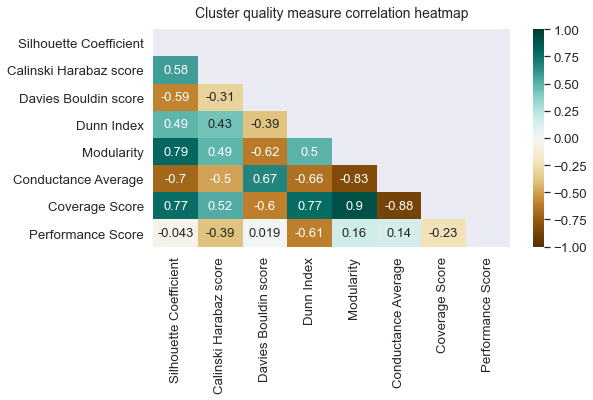

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

_corr_plt_df = _norm_df[lst_norm_cols]
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(_corr_plt_df.corr(), dtype=np.bool))

sns.set(font_scale=1.2)
heatmap = sns.heatmap(_corr_plt_df.corr(), mask=mask,
                      vmin=-1,vmax=1,annot=True,annot_kws={"size": 13},cmap='BrBG')
heatmap.set_title('Cluster quality measure correlation heatmap',fontdict={'fontsize':14}, pad=12)
plt.savefig("../images/outputs/clus_qual_corr_heatmap_"+str(_force_regularity)+".png", bbox_inches="tight")
plt.show()

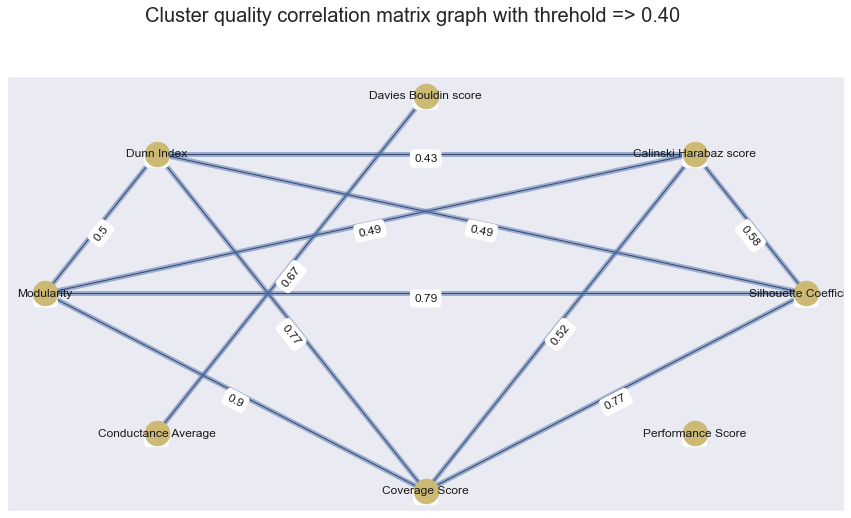

In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

''' set the correlation threshold in the iterval of [-1.0,1.0] it relates to the 
    edge-weights and those edges to remove from the correlation matrix graph '''
_f_corr_thresh = 0.4
''' True: removes all edges => _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)
    False: removes all edges <= _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)'''
_remove_gt = False

''' Construct the correlation matrix graph '''
df_corr = _corr_plt_df.corr().round(2)
G = nx.from_pandas_adjacency(df_corr)
edge_weights = nx.get_edge_attributes(G,'weight')
if _remove_gt:
    G.remove_edges_from((e for e, w in edge_weights.items() if w > _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
else:
    G.remove_edges_from((e for e, w in edge_weights.items() if w < _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
G.name = "Correlation Matrix Graph"

''' Plot the graph with edges representing the correlation '''
plt.figure(figsize=(15,8))
node_pos = pos=nx.circular_layout(G)
#print(node_pos)
nx.draw_networkx(G, node_pos,node_size=600, node_color="y", node_shape='o')
nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b")
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels=edge_labels, label_pos=0.5,
                             font_size=12, font_family="Arial",
                             horizontalalignment='center', verticalalignment='top')
#nx.draw(G)
plt.suptitle(s_title,y=1.0, size=20)
plt.grid(False)
plt.savefig("../images/outputs/clus_qual_corr_g_"+str(_force_regularity)+".png", bbox_inches="tight")
plt.show()

# Identifying the best Quality Measure

## Factor Analysis

In [43]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#factors = _norm_df[lst_norm_cols]
#factors = _minmax_df.loc[_minmax_df["regularity"]=="None"]

''' Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all
    using the observed correlation matrix against the identity matrix'''
chi_square_value,p_value=calculate_bartlett_sphericity(_norm_df[lst_norm_cols])
print("Bartlett sphericity test chi square value: %0.4f and p value: %0.4f" % (chi_square_value, p_value))
''' Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis '''
kmo_all,kmo_model=calculate_kmo(_norm_df[lst_norm_cols])
print("Kaiser-Meyer-Olkin model: %0.4f" % (kmo_model))
fa = FactorAnalyzer()
fa.set_params(n_factors=2, rotation="varimax")
fa.fit(_norm_df[lst_norm_cols])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print("Kaiser criterion > 1.0\n",pd.DataFrame(ev,columns=["Eigen values"]))
_loading_df = pd.DataFrame(fa.loadings_,index=lst_norm_cols,columns=["Factor 0","Factor 1"])
#_loading_df = _loading_df.reindex(sorted(["Factor 0","Factor 1"]), axis=1)
_loading_df=_loading_df.sort_values(["Factor 0","Factor 1"],ascending=False, inplace=False)
print("\nLoading :\n", _loading_df)
#dprint("\nFactor variance:\n",fa.get_factor_variance())
print("\nFactor variance:\n",pd.DataFrame(fa.get_factor_variance(),
                                          index=["Variance","Propotional variance","Cummalative variance"],
                                          columns=["Factor 0","Factor 1"]))
#print("\n",pd.DataFrame(fa.get_communalities(),index=_norm_df[lst_norm_cols].columns,columns=['Communalities']))
_community_df=pd.DataFrame(fa.get_communalities(),index=_norm_df[lst_norm_cols].columns,columns=['Communalities'])
_community_df=_community_df.sort_values(["Communalities"],ascending=False, inplace=False)
print("\nCommunity :\n", _community_df)

Bartlett sphericity test chi square value: 1946.7363 and p value: 0.0000
Kaiser-Meyer-Olkin model: 0.6980
Kaiser criterion > 1.0
    Eigen values
0      4.693366
1      1.205357
2      0.928037
3      0.414557
4      0.384599
5      0.244620
6      0.106181
7      0.023284

Loading :
                         Factor 0  Factor 1
Silhouette Coefficient  0.913282  0.216320
Coverage Score          0.905196  0.118521
Modularity              0.879893  0.241192
Dunn Index              0.480539  0.684709
Calinski Harabaz score  0.378116  0.749567
Performance Score      -0.073807  0.180013
Conductance Average    -0.758021  0.003254
Davies Bouldin score   -0.815490 -0.053936

Factor variance:
                       Factor 0  Factor 1
Variance              4.046632  1.185017
Propotional variance  0.505829  0.148127
Cummalative variance  0.505829  0.653956

Community :
                         Communalities
Silhouette Coefficient       0.880877
Coverage Score               0.833426
Modularity      

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:342: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  error = sp.sum(residual)


## Principal Component Analysis
* [Making sense of PCA](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
* [Reasons for dimensionality reduction](https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b)

In [44]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

factors = _norm_df[lst_norm_cols]
pca=PCA(n_components=3)
pComponents=pca.fit_transform(factors)
pca_df = pd.DataFrame(data = pComponents, columns = ['pcomp-1', 'pcomp-2','pcomp-3'])
print(pca_df)
l_pcs_exp_var=pca.explained_variance_ratio_
print("Explained variance pcomp-1 = %2.2f pcomp-2 = %2.2f pcomp-3 = %2.2f percent" 
      % (l_pcs_exp_var[0]*100,l_pcs_exp_var[2]*100,l_pcs_exp_var[2]*100))

      pcomp-1   pcomp-2   pcomp-3
0   -0.777009 -0.019381 -0.068818
1   -0.839586 -0.041816 -0.076809
2   -0.852713 -0.057466 -0.045701
3   -0.575798  0.160841  0.297312
4   -0.251406  0.630782  0.812990
..        ...       ...       ...
255 -0.971968 -0.109933  0.007395
256 -0.955174 -0.107035 -0.012075
257 -0.954944 -0.179812 -0.009634
258 -0.961015 -0.215864 -0.019815
259 -0.957299 -0.244521 -0.029281

[260 rows x 3 columns]
Explained variance pcomp-1 = 71.83 pcomp-2 = 8.36 pcomp-3 = 8.36 percent


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
print(pca_df["pcomp-1"].lt(0).sum())

139


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Figure size 432x288 with 0 Axes>

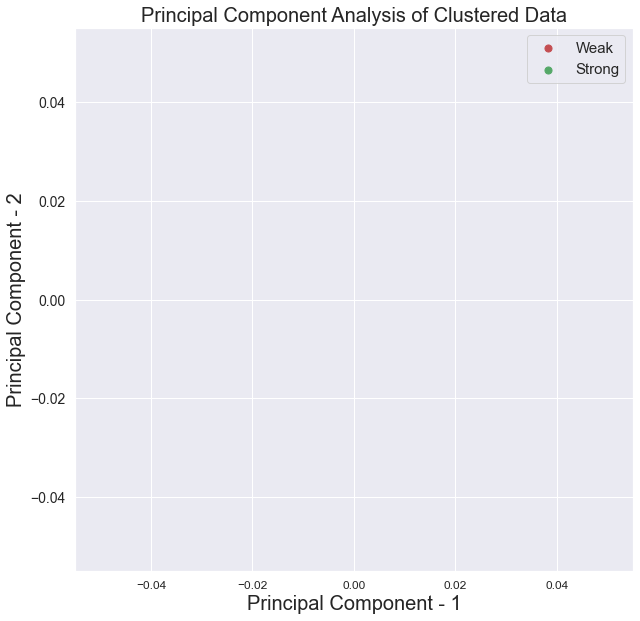

In [12]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Clustered Data",fontsize=20)
targets = ['Weak', 'Strong']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = factors['Coverage Score'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pcomp-1']
               , pca_df.loc[indicesToKeep, 'pcomp-1'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

### Plot quality measures
___TODO___ Change the color palette using a [different method](https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



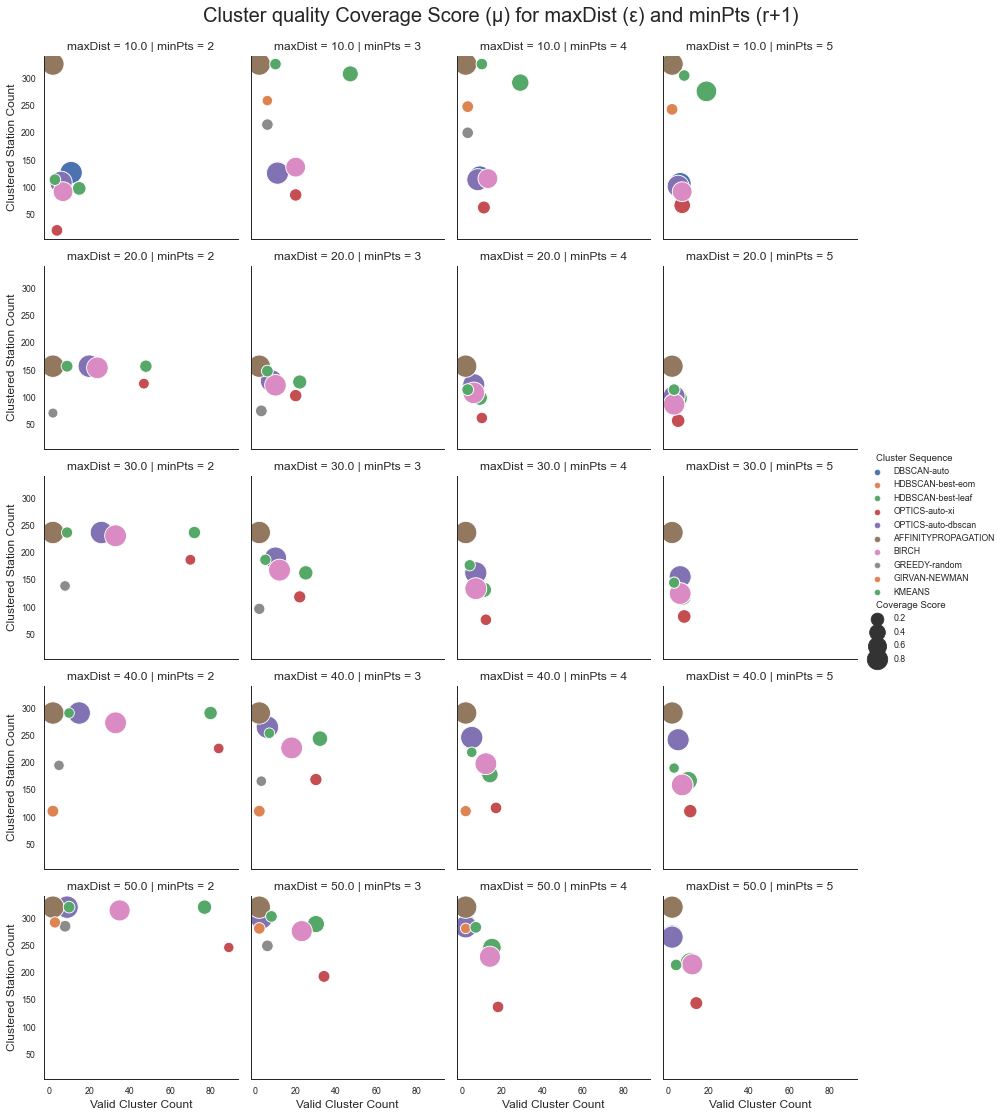

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib
''' @parameter
    use any of the quality measures to view a plot of the cluster sizes and number of stations clustered
    _s_size = {"Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score","Dunn Index",
            "Modularity","Conductance Average","Coverage Score","Performance Score"])
'''
_s_size = "Coverage Score"

''' Copy the dataframe of normalized quality measures '''
#_plot_df = _norm_df.copy()
_plot_df = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]

''' Plot 1.0 - Davies-Bouldin because small value means good clustering; be easier to visualize '''
_plot_df['Davies Bouldin score'] = 1-_plot_df['Davies Bouldin score']

#_plot_df['Dunn Index'] = 1-_plot_df['Dunn Index']

#_plot_df=_plot_df.rename(columns={"Maximum Distance": "maxDistance", "Minimum Points": "minPts"})
#plot_qlty_msr_df=[cloud_norm_df['Method','Cluster Count','Clustered Station Count',
#                          'Minimum Points','Distance','Davies Bouldin score']]
#plt.figure(figsize=(5,5))
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)

#_palette = sns.color_palette("deep",
#                            len(_plot_df["Cluster Sequence"].unique()))

#dprint(len(_plot_df["Cluster Sequence"].unique()))
#d_palette = sns.color_palette("deep",10)

''' Match the colors to the clustering process for plot color consistency '''
_lst_tmp_palette = sns.color_palette("deep", len(_dict_clust_procs))
_palette = []
_lst_procs = [v for k, v in _dict_clust_procs.items()]
for proc_idx, proc_name in enumerate(_lst_procs):
    if proc_name in _plot_df["Cluster Sequence"].unique():
        _palette.append(_lst_tmp_palette[proc_idx])

g=sns.relplot(
    data=_plot_df,
    row='maxDist', col='minPts',
    x="Valid Cluster Count", y="Clustered Station Count",
    hue="Cluster Sequence", size=_s_size,
    palette=_palette, 
    sizes=(100, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

_s_title = "Cluster quality "+_s_size+" (\u03BC) for maxDist (\u03B5) and minPts (r+1)"
plt.suptitle(_s_title,y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot_"+str(_force_regularity)+"_"+_s_size+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
#plt.ion()
plt.show()

## Pivot-table visualization

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_

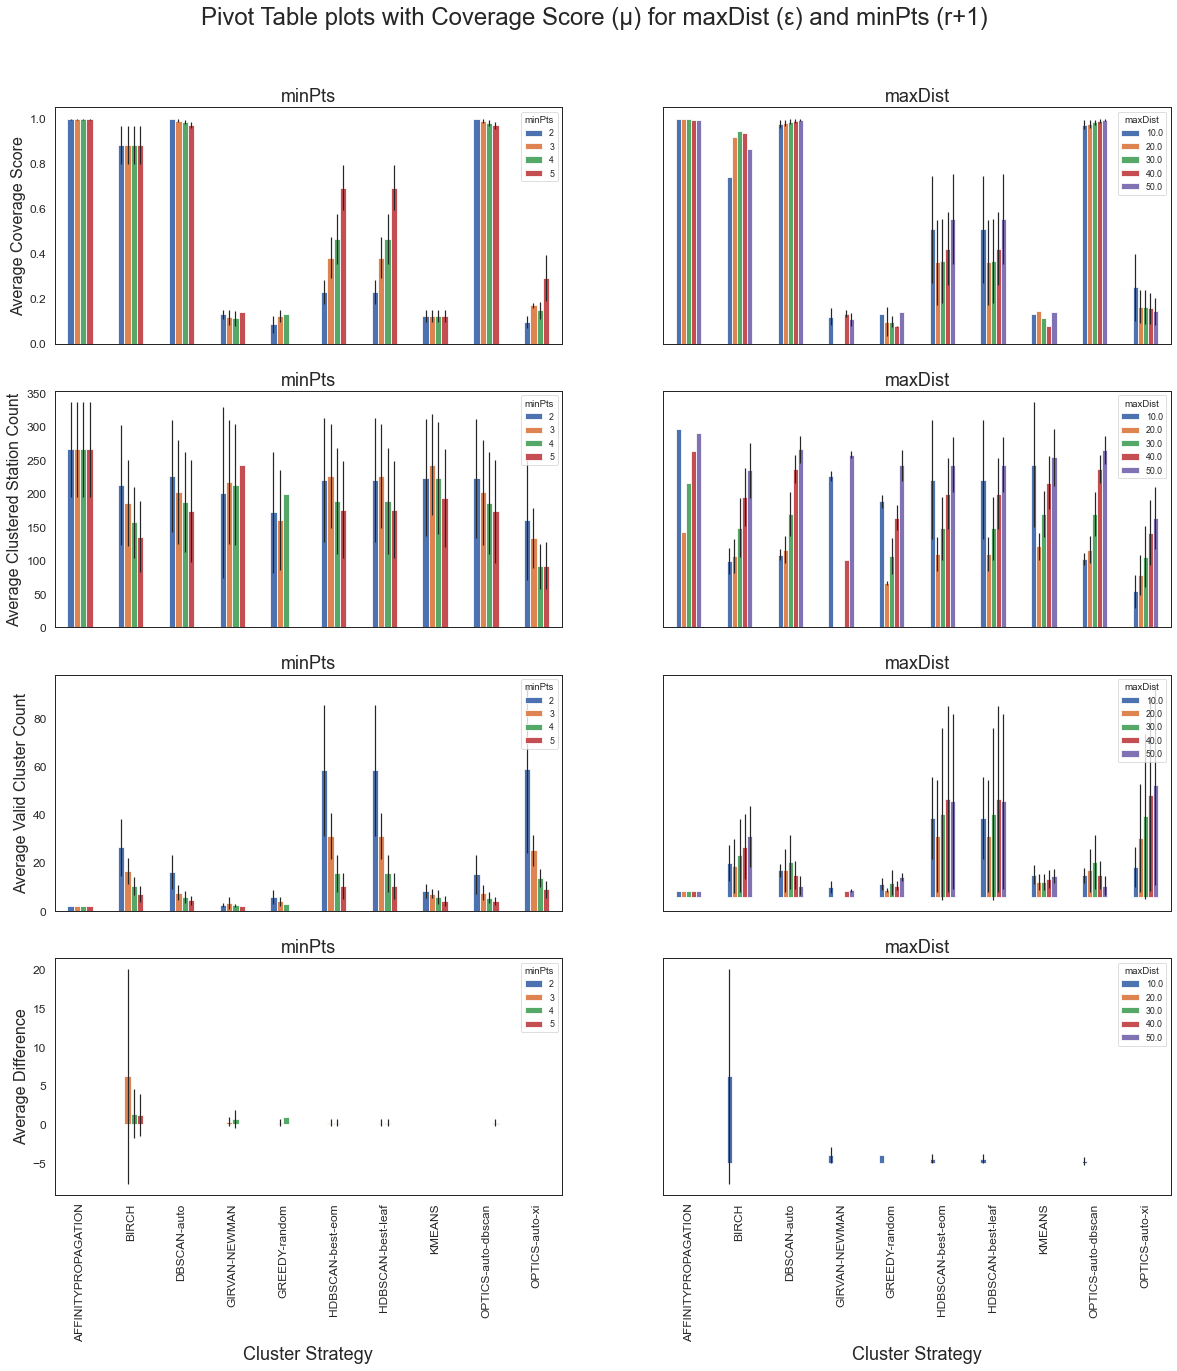

In [106]:
import matplotlib.pyplot as plt
import numpy as np

#_s_qual_mesr = "Silhouette Coefficient"
_s_qual_mesr = _s_size

cols = ["maxDist","minPts","Cluster Sequence", _s_qual_mesr,
        "Generated Cluster Count","Valid Cluster Count","Clustered Station Count"]
#_pivot_df = _norm_df[cols].copy()
#_pivot_df = _scaled_df[cols].copy()
_pivot_df = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]

_pivot_df['Difference'] = (_pivot_df['Generated Cluster Count']
                           - _pivot_df['Valid Cluster Count']).astype(float)

#_pivot_df = _pivot_df[_pivot_df['Difference'] > 0]
_pivot_df=_pivot_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_l_pivtab_cols = ["minPts","maxDist"]
_l_pivtab_vals = [_s_qual_mesr,"Clustered Station Count","Valid Cluster Count","Difference"]

fig, axes = plt.subplots(nrows=len(_l_pivtab_vals),
                         ncols=len(_l_pivtab_cols),
                         figsize=(20,20),
                         sharex=True,
                         #sharey=False
                        )
#plt.rcParams['figure.figsize']=(15,20)
_l_plots = []
for row_num, row_val in enumerate(_l_pivtab_vals):
    for col_num, col_val in enumerate(_l_pivtab_cols):
        _plot_df = _pivot_df.pivot_table(index=["Cluster Sequence"],
                                               #columns=["minPts","maxDist"],
                                               columns=col_val,
                                               values=row_val,
                                               aggfunc=[np.mean, np.std])
        ''' For priniting the data '''
        _l_plots.append(_plot_df)
        
        _plot_df.plot(kind="bar",
                      y="mean",
                      yerr="std",
                      ax=axes[row_num,col_num],
                      #figsize=(10,10),
                      fontsize=12,
                      sharey=True)
        
#        plt.errorbar(x=_plot_df.index, y=_plot_df["mean"], _plot_df["std"], linestyle='None', marker='^')
        axes[row_num,col_num].set_title(col_val,fontdict={'fontsize':18})
        axes[row_num,col_num].set_ylabel("Average "+row_val,fontdict={'fontsize':16})
        axes[row_num,col_num].set_xlabel("Cluster Strategy",fontdict={'fontsize':18})

        _s_title = "Pivot Table plots with "+_s_size+" (\u03BC) for maxDist (\u03B5) and minPts (r+1)"
        plt.suptitle(_s_title,y=0.95, size=24)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/pivot_table_plot_"+
                        str(_force_regularity)+"_"+_s_qual_mesr+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()
#_pivot_df
#

In [107]:
print(_l_plots[0],'\n', _l_plots[1])

                         mean                                     std  \
minPts                      2         3         4         5         2   
Cluster Sequence                                                        
AFFINITYPROPAGATION  0.997792  0.997792  0.997792  0.997792  0.002053   
BIRCH                0.883140  0.883140  0.883140  0.883140  0.084270   
DBSCAN-auto          1.000000  0.991722  0.984261  0.972772  0.000000   
GIRVAN-NEWMAN        0.130460  0.117292  0.112986  0.139971  0.020244   
GREEDY-random        0.087186  0.122559  0.133868       NaN  0.037211   
HDBSCAN-best-eom     0.230210  0.382131  0.465933  0.694093  0.055287   
HDBSCAN-best-leaf    0.230210  0.382131  0.465933  0.694093  0.055287   
KMEANS               0.122559  0.122559  0.122559  0.122559  0.027148   
OPTICS-auto-dbscan   1.000000  0.990036  0.980071  0.970247  0.000000   
OPTICS-auto-xi       0.094571  0.170774  0.148351  0.291216  0.026596   

                                                  

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Degree validation

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



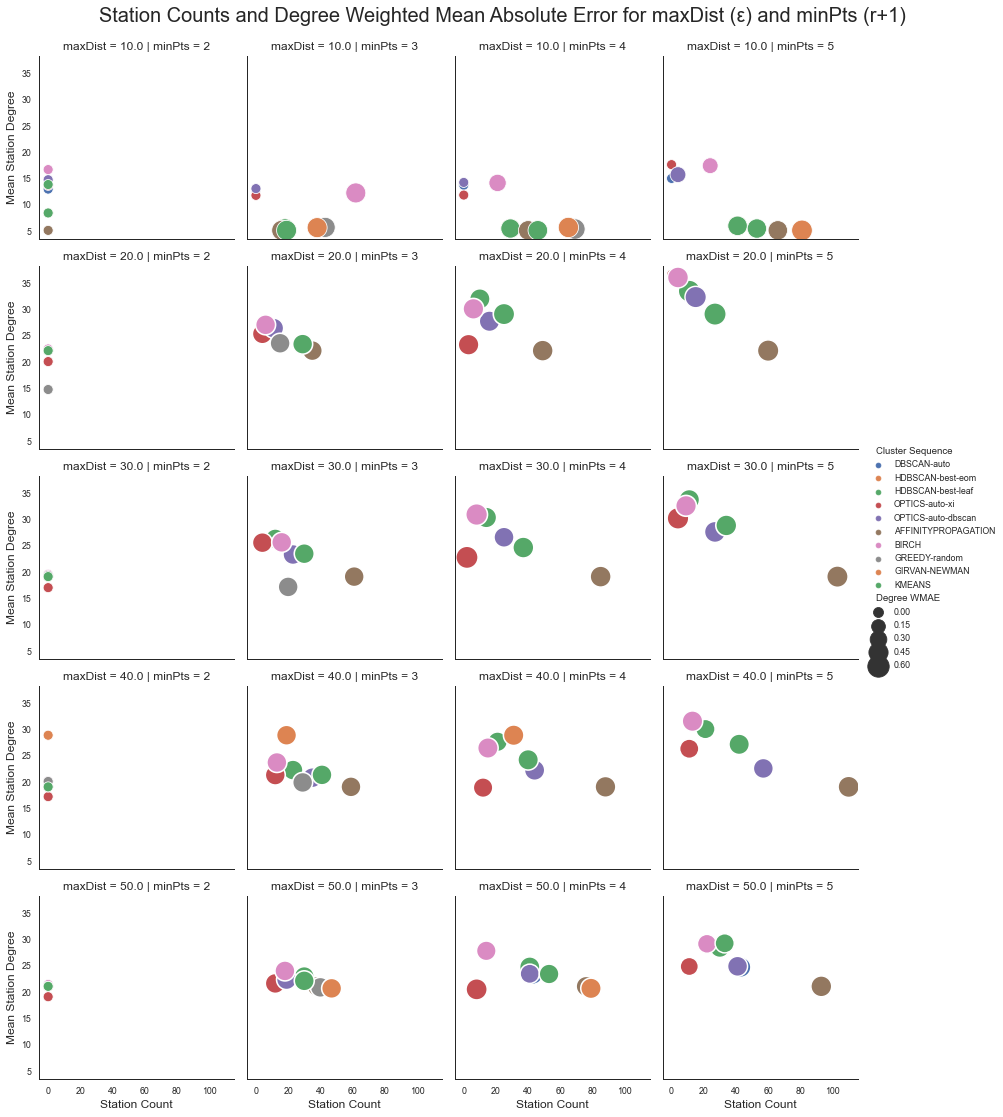

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib
''' Copy the dataframe of normalized quality measures '''
#_deg_plot_df = _norm_df.copy()
#_deg_plot_df = _scaled_df.copy()
_deg_plot_df = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]

''' Plot 1.0 - Davies-Bouldin because small value means good clustering; be easier to visualize '''
_deg_plot_df['Davies Bouldin score'] = 1-_deg_plot_df['Davies Bouldin score']
#_plot_df['Dunn Index'] = 1-_plot_df['Dunn Index']

_deg_plot_df=_deg_plot_df.rename(columns={"Degree Weighted Mean Absolute Error": "Degree WMAE",
                                          "Degree Error Station Count": "Station Count",
                                          "Average Station Degree": "Mean Station Degree"})
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)

#_palette = sns.color_palette("deep",
#                            len(_plot_df["Cluster Sequence"].unique()))

#dprint(len(_plot_df["Cluster Sequence"].unique()))
#d_palette = sns.color_palette("deep",10)

''' Match the colors to the clustering process for plot color consistency '''
_lst_tmp_palette = sns.color_palette("deep", len(_dict_clust_procs))
_palette = []
_lst_procs = [v for k, v in _dict_clust_procs.items()]
for proc_idx, proc_name in enumerate(_lst_procs):
    if proc_name in _deg_plot_df["Cluster Sequence"].unique():
        _palette.append(_lst_tmp_palette[proc_idx])

g=sns.relplot(
    data=_deg_plot_df,
    row='maxDist', col='minPts',
    x="Station Count", y="Mean Station Degree",
    hue="Cluster Sequence", size="Degree WMAE",
    palette=_palette, 
    sizes=(100, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

_s_title = "Station Counts and Degree Weighted Mean Absolute Error for maxDist (\u03B5) and minPts (r+1)"
plt.suptitle(_s_title,y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/degree_err_relplot_"+str(_force_regularity)+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
#plt.ion()
plt.show()

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



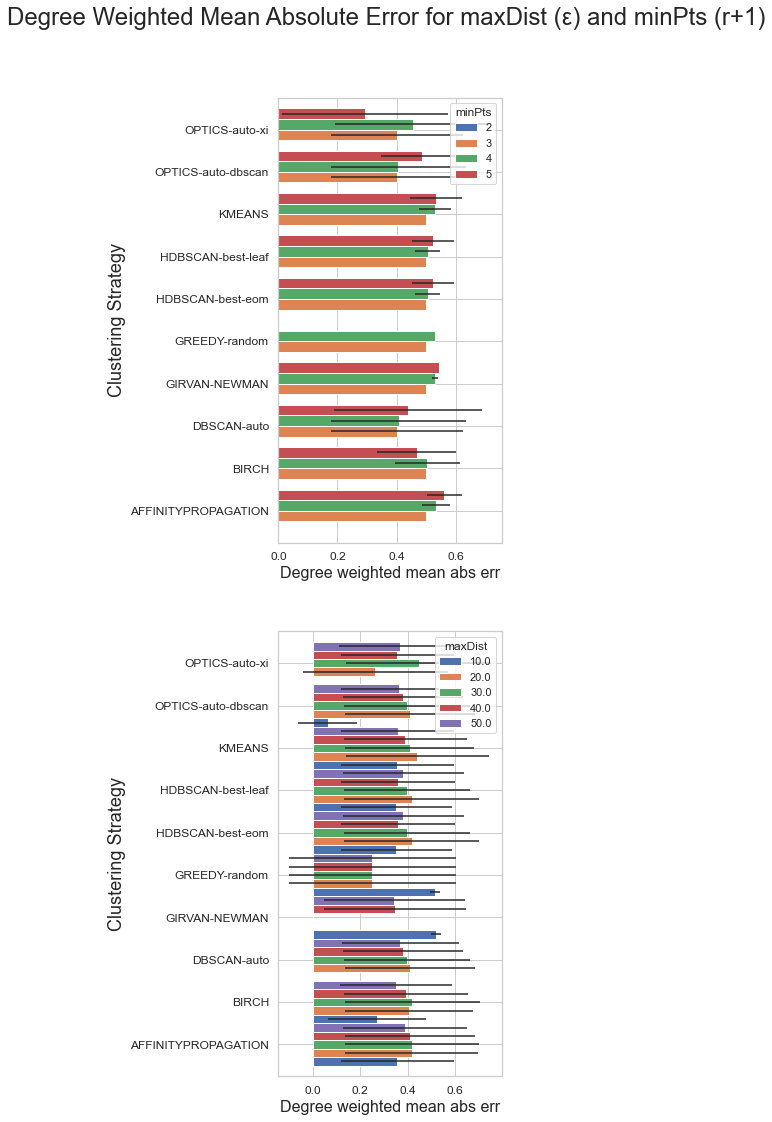

In [109]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
#d sns.set_theme(style="ticks", palette="pastel")

''' copy and build dataset from _norm_df '''
cols = ["Cluster Sequence","maxDist","minPts","Average Station Degree",
        "Degree Weighted Mean Absolute Error","Degree Error Station Count"]
#_deg_err_df = _norm_df[cols].copy()
_deg_err_df = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]

#_pivot_df = _pivot_df[_pivot_df['Difference'] > 0]
_deg_err_df=_deg_err_df.rename(columns={"Degree Weighted Mean Absolute Error": "Degree WMAE",
                                        "Degree Error Station Count": "Degree Err Stations",
                                        "Average Station Degree": "Mean Degree"})
#_snr_df.sort_values(by=['Cluster Sequence'], ascending=False)
_order = _deg_err_df["Cluster Sequence"].unique()
_l_deg_plot_rows=["minPts","maxDist"]
_l_deg_plot_data = []

fig, axes = plt.subplots(nrows=len(_l_deg_plot_rows),
                         ncols=1,
                         figsize=(4,18),
                         sharex=False,
                         #sharey=False
                        )

for row_num, row_val in enumerate(_l_deg_plot_rows):
    _deg_plot_df = _deg_err_df.pivot_table(index=["Cluster Sequence"],
                                           columns=row_val,
                                           #rows=row_val,
                                           values="Degree WMAE",
                                           aggfunc=[np.mean, np.std])
    _l_deg_plot_data.append(_deg_plot_df)
    _deg_plot_df.plot(kind="barh",
                      y="mean",
                      xerr="std",
                      ax=axes[row_num],
                      #figsize=(10,10),
                      fontsize=12,
                      width=1,
                      #sharey=True
                     )
    
#    axes[row_num].set_title("SNR",fontdict={'fontsize':18})
    axes[row_num].set_xlabel("Degree weighted mean abs err",fontdict={'fontsize':16})
    axes[row_num].set_ylabel("Clustering Strategy",fontdict={'fontsize':18})
    
    _s_title = "Degree Weighted Mean Absolute Error for maxDist (\u03B5) and minPts (r+1)"
    plt.suptitle(_s_title,y=0.95, size=24)


_s_plot_save_file = str("../images/outputs/degree_err_barh_plot_"+
                        str(_force_regularity)+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()

### Station to Noise Ratio

___TODO___ evaluate in terms of Specificity https://clusteval.sdu.dk/1/clustering_quality_measures/3 

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



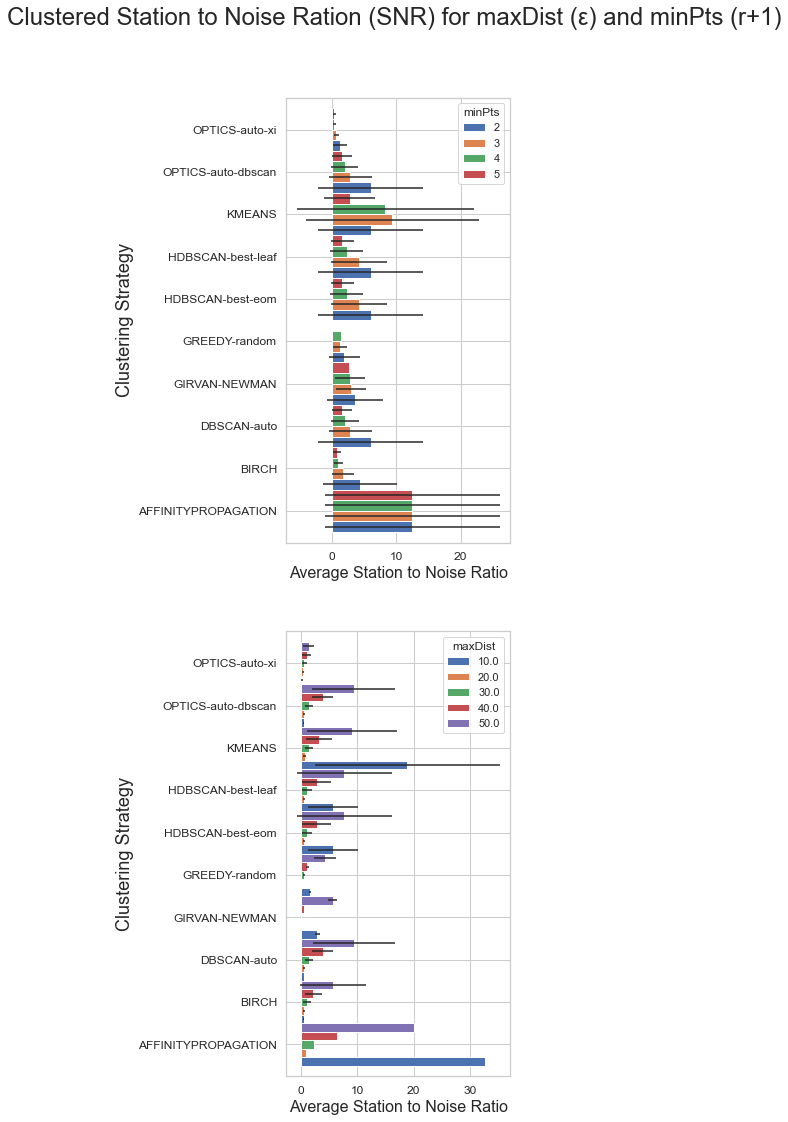

In [110]:
import seaborn as sns
sns.set_theme(style="whitegrid")
#d sns.set_theme(style="ticks", palette="pastel")

''' copy and build dataset from _norm_df '''
cols = ["Cluster Sequence","maxDist","minPts","Clustered Station Count","Unclsutered Noise Count"]
#_snr_df = _norm_df[cols].copy()
_snr_df = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]

_snr_df['SNR'] = (_snr_df['Clustered Station Count']/_snr_df['Unclsutered Noise Count']).astype(float)

#_pivot_df = _pivot_df[_pivot_df['Difference'] > 0]
_snr_df=_snr_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
#_snr_df.sort_values(by=['Cluster Sequence'], ascending=False)
_order = _snr_df["Cluster Sequence"].unique()
_l_snr_plot_rows=["minPts","maxDist"]
_l_plot_data = []

fig, axes = plt.subplots(nrows=len(_l_snr_plot_rows),
                         ncols=1,
                         figsize=(4,18),
                         sharex=False,
                         #sharey=False
                        )

for row_num, row_val in enumerate(_l_snr_plot_rows):
    _plot_df = _snr_df.pivot_table(index=["Cluster Sequence"],
                                   columns=row_val,
                                   #rows=row_val,
                                   values="SNR",
                                   aggfunc=[np.mean, np.std])
    _l_plot_data.append(_plot_df)
    _plot_df.plot(kind="barh",
                  y="mean",
                  xerr="std",
                  ax=axes[row_num],
                  #figsize=(10,10),
                  fontsize=12,
                  width=1,
                  sharey=True)
    
#    axes[row_num].set_title("SNR",fontdict={'fontsize':18})
    axes[row_num].set_xlabel("Average Station to Noise Ratio",fontdict={'fontsize':16})
    axes[row_num].set_ylabel("Clustering Strategy",fontdict={'fontsize':18})
    
    _s_title = "Clustered Station to Noise Ration (SNR) for maxDist (\u03B5) and minPts (r+1)"
    plt.suptitle(_s_title,y=0.95, size=24)


_s_plot_save_file = str("../images/outputs/SNR_plot_"+
                        str(_force_regularity)+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()

In [99]:
print(_l_plot_data[0],'\n', _l_plot_data[1])

                          mean                                         std  \
minPts                       2          3          4          5          2   
Cluster Sequence                                                             
AFFINITYPROPAGATION  12.467540  12.467540  12.467540  12.467540  13.545112   
ASYNC-LPA-random      2.629910   2.476283   2.608628   2.241308   2.216148   
BIRCH                 5.922892   3.661294   2.582926   1.815146   8.187892   
DBSCAN-auto           6.085229   4.190179   3.409719   2.025424   8.118527   
GIRVAN-NEWMAN         3.905187   3.775661   3.622877   3.599478   3.884284   
GREEDY-integer        3.959439   4.012362   3.895755   3.802019   3.707796   
GREEDY-random         3.517999   4.012362   3.895755   3.802019   3.740918   
HDBSCAN-best-eom      6.241658   5.975270   4.106582   4.042338   7.995142   
HDBSCAN-best-leaf     6.241658   5.975270   4.106582   4.042338   7.995142   
KMEANS               12.467540  12.459334  12.439370  12.431515 

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Difference between Generated and Valid clusters

In [111]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import ks_2samp
#import seaborn as sns
#import matplotlib.pyplot as plt
#%matplotlib inline

cols = ['maxDist','minPts','Cluster Sequence','Generated Cluster Count','Valid Cluster Count']
#_df_clust_diff = _results_df[cols].copy()
_df_clust_diff = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]
_df_clust_diff = _df_clust_diff[cols]

_df_clust_diff['Difference'] = (_df_clust_diff['Generated Cluster Count'] 
                                - _df_clust_diff['Valid Cluster Count']).astype(float)
''' consider only records with difference != 0 '''
_diff_df = _df_clust_diff[_df_clust_diff['Difference'] > 0]
''' apply two sample KS-test to all sequences '''
_plot_df=pd.DataFrame([], columns=['Sequence','maxDiff','1-Pvalue'])
for each_seq in _diff_df['Cluster Sequence'].unique():
    _df_temp = _diff_df[_diff_df['Cluster Sequence'] ==each_seq]
    stat, pval = ks_2samp(_df_temp['Generated Cluster Count'],_df_temp['Valid Cluster Count'])
    _plot_df=_plot_df.append({'Sequence':each_seq,'maxDiff':stat, '1-Pvalue':1-pval}, ignore_index=True)

categories = _plot_df['Sequence'].to_list()
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=_plot_df['1-Pvalue'],
      theta=categories,
      fill='toself',
      name='1-Pvalue'
))
fig.add_trace(go.Scatterpolar(
      r=_plot_df['maxDiff'],
      theta=categories,
      fill='toself',
      name='maxDiff'
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True,range=[0, 1])),
    title_font_color="red",
    title={'text': "KS Test of Sequences with Differences between Generated and Valid Clusters",
           'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01)
)
''' Need to install kaleido to write image to file'''
#_s_plot_save_file = str("../images/outputs/radar_plot_ks_test.png").replace(" ","_")
#fig.write_image(_s_plot_save_file)
fig.show()

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



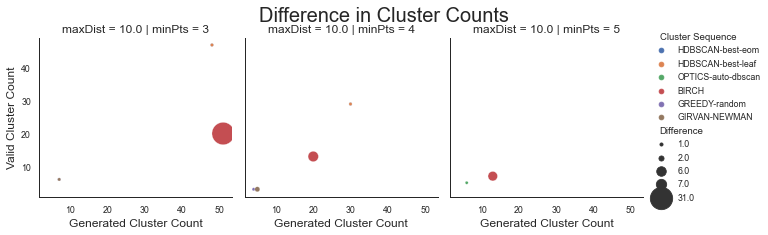

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cols = ['maxDist','minPts','Cluster Sequence',
        'Generated Cluster Count','Valid Cluster Count']
#_df_clust_diff = _results_df[cols].copy()
_df_clust_diff = _scaled_df.loc[_scaled_df["regularity"]==_force_regularity]
_df_clust_diff = _df_clust_diff[cols]

_df_clust_diff['Difference'] = (_df_clust_diff['Generated Cluster Count'] 
                                - _df_clust_diff['Valid Cluster Count']).astype(float)
_df_clust_diff = _df_clust_diff[_df_clust_diff['Difference'] > 0]
_df_clust_diff=_df_clust_diff.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)
#g = sns.FacetGrid(data=_df_clust_diff, col="minPts", row="maxDistance")
#g.map(sns.histplot, x=_df_clust_diff["Difference"])

g=sns.relplot(
    data=_df_clust_diff,
    row='maxDist', col='minPts',
    x="Generated Cluster Count", y="Valid Cluster Count",
    hue="Cluster Sequence", size="Difference",
    palette='deep', sizes=(10, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

#for i,ax in enumerate(g.axes):
#    ax[i,0].axhline(200, ls='--', linewidth=3, color='red')

plt.suptitle("Difference in Cluster Counts",y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot_clus_diff_"+str(_force_regularity)+".png")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()

## Redundant Code

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


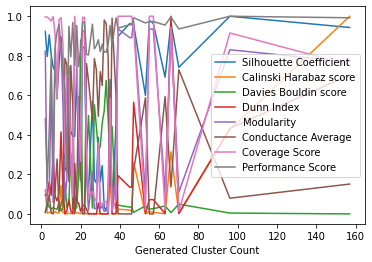

In [5]:
''' DEPRECATED doesn\'t really do much '''
import matplotlib.pyplot as plt

group_df = _norm_df.groupby("Generated Cluster Count")[["Silhouette Coefficient",
                                                        "Calinski Harabaz score",
                                                        "Davies Bouldin score",
                                                        "Dunn Index",
                                                        "Modularity",
                                                        "Conductance Average",
                                                        "Coverage Score",
                                                        "Performance Score"]].mean()
#group_df = _norm_df[["Generated Cluster Count","Silhouette Coefficient"]]

#print(group_df.head)
#plt.plot(group_df, '-o')
group_df.plot()
plt.show()

In [ ]:
''' DEPRECATED using factor analysis '''

from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
_norm_df = _results_df.copy()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(_norm_df[lst_norm_cols])
principal_df = pd.DataFrame(data = principalComponents
                            , columns = ['PC1', 'PC2'])
print(pca.explained_variance_ratio_)
#for col in principalDf['PC1', 'PC2']:
_norm_df["Principal Component"] = pd.DataFrame(scaler.fit_transform
                                               (np.array(principal_df["PC1"]).reshape(-1,1))
                                              )
#_norm_df["Principal Component"] = np.array(principal_df["PC1"])
_norm_df = _norm_df.dropna()
#print('Normalization complete!')
#_norm_df["Principal Component"] = principalDf["PC1"]

print('PCA and Normalization complete!')

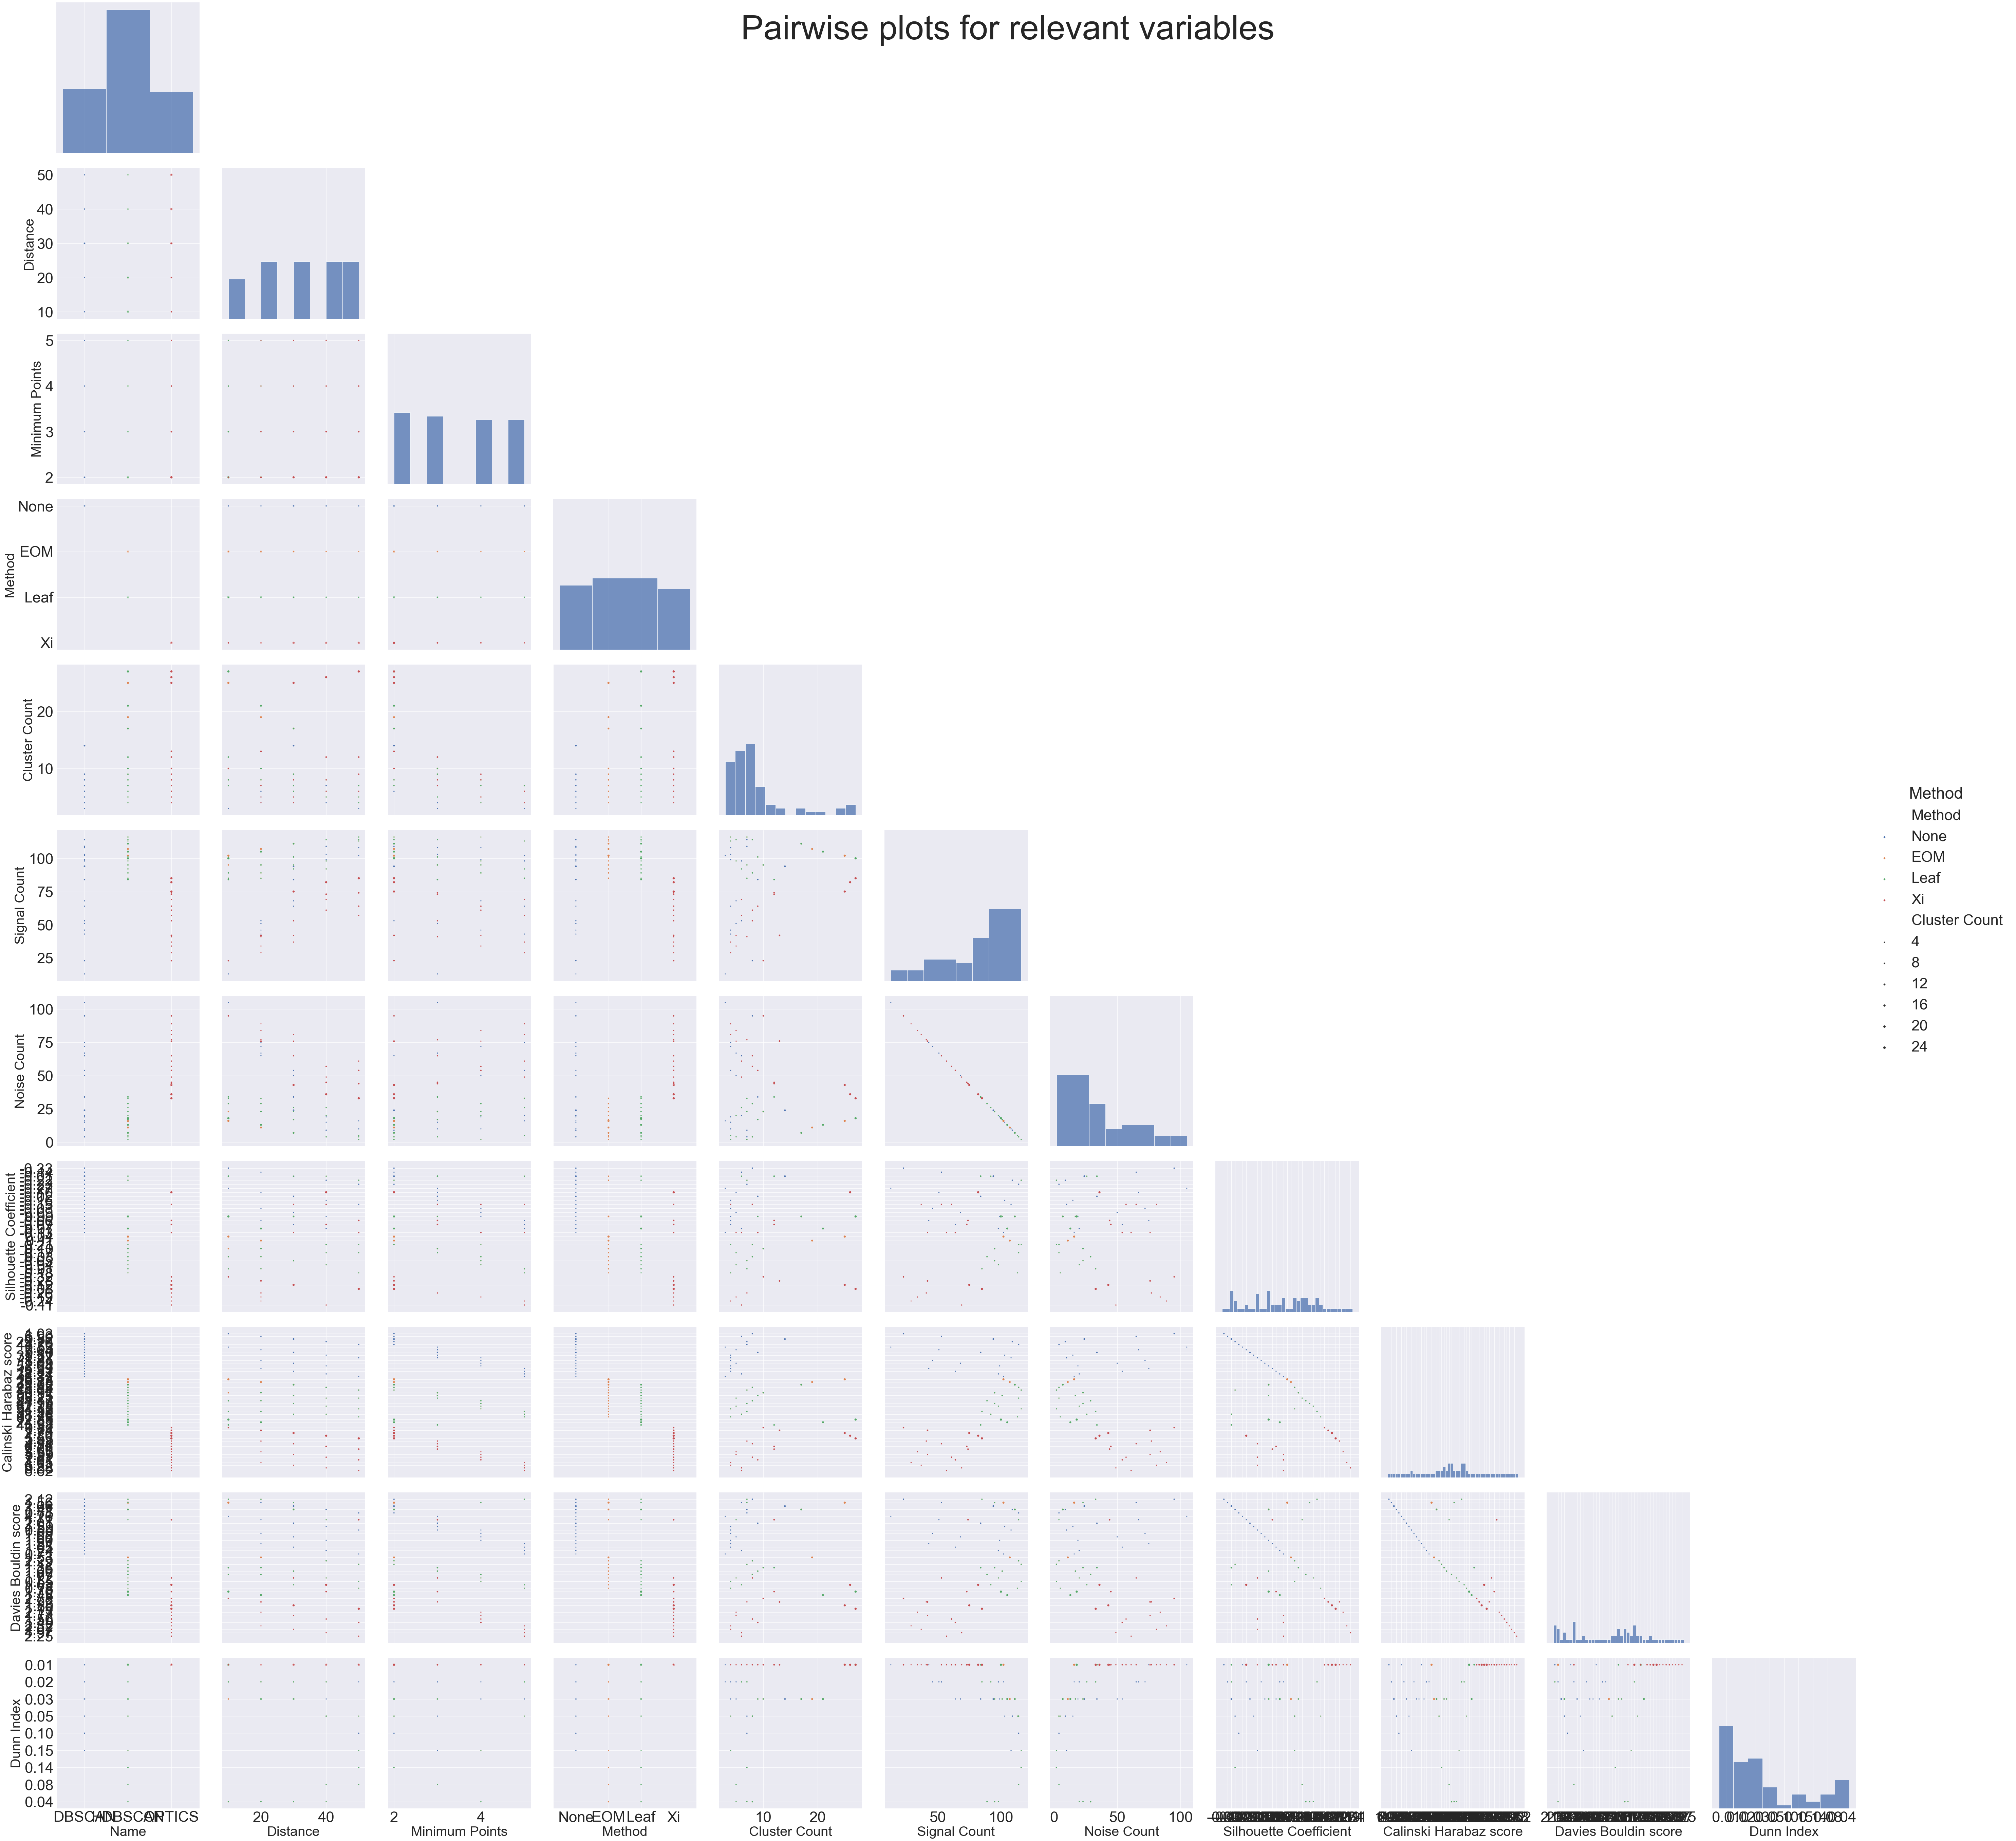

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pg_plot_df = cloud_clust_df.copy()
lst_vars = list(pg_plot_df.columns)
#lst_vars = list([''])
#x_vars=[cloud_clust_df['Distance'],cloud_clust_df['Minimum Points'],
#        cloud_clust_df['Cluster Count'],cloud_clust_df['Signal Count'],
#        cloud_clust_df['Noise Count']]
#y_vars=[cloud_clust_df['Silhouette Coefficient'],cloud_clust_df['Calinski Harabaz score'],
#        cloud_clust_df['Davies Bouldin score'],cloud_clust_df['Dunn Index']]
sns.color_palette("husl", 4)
sns.set_context("paper", rc={"font.size":8, "axes.labelsize":40}, font_scale=5)
''' kind = hist, scatter, '''
#g = sns.PairGrid(cloud_clust_df, hue='Method_Code', corner=True,hue_order=None,
#                 kind='scatter', diag_kind='hist', height=7,markers='o',
#                 plot_kws={"s": 200}, color=".3")
g = sns.PairGrid(pg_plot_df, hue="Method", vars=lst_vars, corner=True, height=7)
g.map_diag(sns.histplot, hue=None)
#g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot)
g.map_offdiag(sns.scatterplot,s=200, size=pg_plot_df["Cluster Count"])
g.fig.suptitle("Pairwise plots for relevant variables", size=100) # y= some height > 1
g.add_legend()
#g.fig.legend(markerscale=2)
plt.show()

In [ ]:
from scipy.stats import normaltest, ansari, chisquare, chi2, chi2_contingency
import numpy as np

_hypo_test_df = _norm_df.copy()

for p_mesr_idx, p_mesr_name in enumerate(lst_norm_cols):
    p_mesr_arr = _hypo_test_df[p_mesr_name].to_numpy()
    s_norm = ""
    s_chisqr = ""
    norm_stat, norm_p = normaltest(p_mesr_arr)
    chisqr_sta, chisqr_p = chisquare(p_mesr_arr)

    if norm_p < 0.05:
        s_norm = '[Normal distribution]'
    if chisqr_p < 0.05:
        s_chisqr = "[Chisquare]"
    print('%s Mean = %0.04f & Variance = %0.04f %s %s' 
          % (p_mesr_name, np.mean(p_mesr_arr), np.var(p_mesr_arr), s_norm, s_chisqr))
    
    for s_mesr_idx, s_mesr_name in enumerate(lst_norm_cols):
        if s_mesr_idx > p_mesr_idx:
            validity_data = np.array([_hypo_test_df[p_mesr_name],_hypo_test_df[s_mesr_name]])
#            chi_stat, chi_p, chi_dof, expected = chi2_contingency(validity_data,correction=False)
#            print(validity_data[0],validity_data[1])
            ans_stat, ans_p = ansari(validity_data[0],validity_data[1])
#            print('H0: %s is different from %s stat: %0.04f p-value: %0.04f dof: %0.04f' 
#                  % (p_mesr_name,s_mesr_name, stat, p, dof))
            if ans_p < 0.05:
                print('Different from %s with p-value: %0.04f' % (s_mesr_name, ans_p))
            else:
                print('Same as %s with p-value: %0.04f' % (s_mesr_name, ans_p))
    print()